In [3]:

kutA = 0.479
ktdA = 0.213
ksdA = 0.5057
kusA = 0.0532
ktu0 = 0.21
kdt0 = 0
kds0 = 0.31
ksu0 = 0.11
ktuA = 0.0798
kdtA = 0.173
kdsA = -0.32
ksuA = -0.13

kbc = 0.133

K05 = 0.43
KaiC = 3.4
M = 5
N = 0.1
Krel = 1

def model_phong(xyz, t, percATP, KaiA, eps):
    currU, currS, currT, currD, currSTB, currSB  = xyz
    #now with leakiness!
    A = max(0, KaiA - N*KaiC*currSTB - M*KaiC*currSB)
    
    ATP = percATP
    ADP = 1 - percATP
    
    kut = ATP/(ATP + Krel*ADP) * (kutA*(A+eps))/(K05 + A + eps) 
    ktd = ATP/(ATP + Krel*ADP) * (ktdA*(A+eps))/(K05 + A + eps) 
    ksd = ATP/(ATP + Krel*ADP) * (ksdA*(A+eps))/(K05 + A + eps)
    kus = ATP/(ATP + Krel*ADP) * (kusA*(A+eps))/(K05 + A + eps)
    ktu = ktu0 + (ktuA*A)/(K05 + A)
    kdt = kdt0 + (kdtA*A)/(K05 + A)
    kds = kds0 + (kdsA*A)/(K05 + A)
    ksu = ksu0 + (ksuA*A)/(K05 + A)
    ksbd=ksd

    dUdt = ktu*currT + ksu*currS + ksu*currSB - kut*currU - kus*currU
    dSdt = kus*currU + kds*currD - ksu*currS - ksd*currS - kbc*currS
    dTdt = kut*currU + kdt*currD - ktu*currT - ktd*currT + kdt*currSTB 
    dDdt = ktd*currT + ksd*currS - kdt*currD - kds*currD - kbc*currD
    dSTBdt = kbc*currD + ksd*currSB - kds*currSTB - kdt*currSTB        
    dSBdt = kbc*currS + kds*currSTB - ksd*currSB - ksu*currSB
    
    return [dUdt, dSdt, dTdt, dDdt, dSTBdt, dSBdt]

In [5]:
def integrate_model(func_rhs, xyz_0, t_int, params):
    #func_rhs: name of RHS function to integrate
    #xyz_0: initial conditions
    #t_int: how long to integrate for
    #params: parameters to pass to the model
    
    #should return the time series
    tlist = np.linspace(0,t_int,50000)
    xyz_output = odeint(func_rhs, xyz_0, tlist, args=params)
    
    return (xyz_output, tlist)

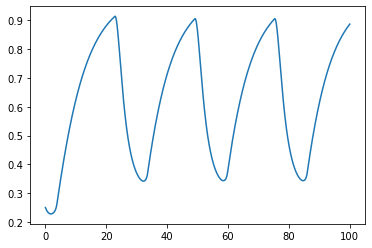

In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
xyz_0 = [0.25, 0.25, 0.25, 0.25, 0, 0]
params = (1, 1.3, 0.0)
xyz_output, tlist = integrate_model(model_phong, xyz_0, 100, params)
plt.plot(tlist,xyz_output[:,0])

In [9]:
from scipy.signal import find_peaks
def get_amplitude_per_phong(model, params):
    #call the integrator to solve the ODEs
    TOL = 0.001
    MAXTRIES = 8
    tries = 0
    t_int = 100
    xyz_0 = [0.25, 0.25, 0.25, 0.25, 0, 0]
    xyz_output, tlist = integrate_model(model, xyz_0, t_int, params)
    x_vals = xyz_output[:,0]
    x_max = max(x_vals[int(len(x_vals)/2):-1])
    x_min = min(x_vals[int(len(x_vals)/2):-1])
    amp = (x_max - x_min)/2
    done = False
    while not done:
        old_amp = amp
        t_int = t_int * 2
        xyz_output, tlist = integrate_model(model, xyz_0, t_int, params)
        x_vals = xyz_output[:,0]
        x_max = max(x_vals[int(len(x_vals)/2):-1])
        x_min = min(x_vals[int(len(x_vals)/2):-1])
        amp = (x_max - x_min)/2
        tries = tries + 1
        if amp < TOL or abs(amp-old_amp) < TOL or tries > MAXTRIES:
            done = True
    peaks, _ = find_peaks(x_vals, height=0)
    
    if amp > TOL:
        return amp, abs(tlist[peaks[-1]] - tlist[peaks[-2]])
    else:
        return 0, 0

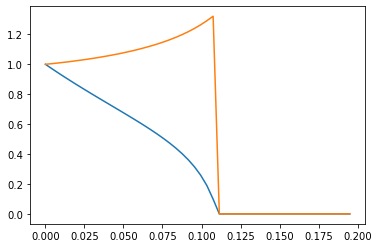

In [16]:
epslindex = np.linspace(0,0.15,50)
amplist = np.linspace(0.1,0.3,50)
perlist = np.linspace(0.1,0.3,50)
for i in range(len(epslindex)):
    amplist[i], perlist[i] = get_amplitude_per_phong(model_phong,(1,1.3,epslindex[i]))
    if amplist[i] < amplist[0]*0.05:
        perlist[i] = 0
plt.plot(1.3*epslindex,amplist/amplist[0])
plt.plot(1.3*epslindex,perlist/perlist[0])

In [12]:
perlist/perlist[0]

array([1.        , 1.00412277, 1.00855092, 1.01328447, 1.01832341,
       1.02382043, 1.02947015, 1.03542526, 1.04183845, 1.04870973,
       1.05603909, 1.06367384, 1.07176668, 1.08077569, 1.09009009,
       1.10016796, 1.11116201, 1.12276683, 1.13528783, 1.14903039,
       1.1639945 , 1.18018018, 1.1981982 , 1.21789586, 1.23973126,
       1.26400977, 1.29149488, 1.32111773, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [13]:
amplist/amplist[0]

array([1.        , 0.97175157, 0.94414911, 0.9171324 , 0.89064179,
       0.86461728, 0.83899789, 0.81372027, 0.78871903, 0.76392375,
       0.73925908, 0.71464217, 0.68998071, 0.66516997, 0.6400887 ,
       0.61459484, 0.58851716, 0.56164651, 0.53372225, 0.50441388,
       0.47327858, 0.43973495, 0.40297085, 0.36182493, 0.3145629 ,
       0.25846988, 0.18907503, 0.09849838, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [17]:
epslindex*1.3

array([0.        , 0.00397959, 0.00795918, 0.01193878, 0.01591837,
       0.01989796, 0.02387755, 0.02785714, 0.03183673, 0.03581633,
       0.03979592, 0.04377551, 0.0477551 , 0.05173469, 0.05571429,
       0.05969388, 0.06367347, 0.06765306, 0.07163265, 0.07561224,
       0.07959184, 0.08357143, 0.08755102, 0.09153061, 0.0955102 ,
       0.0994898 , 0.10346939, 0.10744898, 0.11142857, 0.11540816,
       0.11938776, 0.12336735, 0.12734694, 0.13132653, 0.13530612,
       0.13928571, 0.14326531, 0.1472449 , 0.15122449, 0.15520408,
       0.15918367, 0.16316327, 0.16714286, 0.17112245, 0.17510204,
       0.17908163, 0.18306122, 0.18704082, 0.19102041, 0.195     ])